In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters

<function pandas.plotting._misc.register()>

In [2]:
if torch.cuda.is_available():
    use_CUDA = True
    print(f"You are using: {torch.cuda.get_device_name()}")
else:
    use_CUDA = False
    print(f"You are using: CPU")

You are using: NVIDIA GeForce RTX 3080


In [3]:
df = pd.read_csv("../Data/TimeSeriesData/Alcohol_Sales.csv", index_col=0, parse_dates=True)

In [4]:
df

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


In [5]:
df = df.dropna()

In [6]:
df

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


<AxesSubplot:xlabel='DATE'>

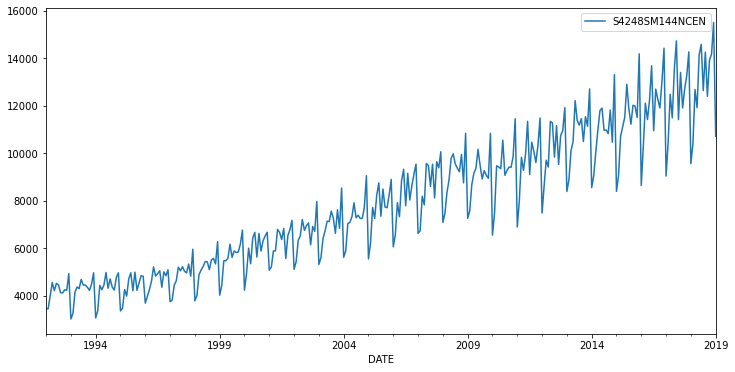

In [7]:
df.plot(figsize=(12,6))

In [8]:
y = df['S4248SM144NCEN'].values.astype('float')

In [9]:
test_size = 12

In [10]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [14]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [15]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [16]:
# len(y) - test_size - window_size

In [17]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [18]:
if use_CUDA:
    train_norm = train_norm.cuda()

In [19]:
window_size = 12

In [20]:
def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    
    return out

In [21]:
train_data = input_data(train_norm, window_size)

In [22]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=200, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction

In [24]:
torch.manual_seed(101)

model = LSTMnetwork().cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
model

LSTMnetwork(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

In [27]:
epochs = 150

import time 
start_time = time.time()


for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                       torch.zeros(1,1,model.hidden_size).cuda())
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch+1} Loss: {loss.item()}")

total_time = time.time() - start_time
print(f"Total time: {total_time/60}mins")

Epoch: 1 Loss: 0.3978264033794403
Epoch: 2 Loss: 0.3935987949371338
Epoch: 3 Loss: 0.23170381784439087
Epoch: 4 Loss: 0.4617188572883606
Epoch: 5 Loss: 0.37591439485549927
Epoch: 6 Loss: 0.37924638390541077
Epoch: 7 Loss: 0.3701454699039459
Epoch: 8 Loss: 0.17610806226730347
Epoch: 9 Loss: 0.004956345539540052
Epoch: 10 Loss: 0.014780072495341301
Epoch: 11 Loss: 0.1647120714187622
Epoch: 12 Loss: 0.3121860921382904
Epoch: 13 Loss: 0.08934436738491058
Epoch: 14 Loss: 0.261689692735672
Epoch: 15 Loss: 0.10382933914661407
Epoch: 16 Loss: 0.07612523436546326
Epoch: 17 Loss: 0.04496688023209572
Epoch: 18 Loss: 0.013684151694178581
Epoch: 19 Loss: 0.006287694908678532
Epoch: 20 Loss: 0.00011312722926959395
Epoch: 21 Loss: 0.0020014001056551933
Epoch: 22 Loss: 0.000966739549767226
Epoch: 23 Loss: 0.001567760482430458
Epoch: 24 Loss: 0.0006836032844148576
Epoch: 25 Loss: 0.000801502144895494
Epoch: 26 Loss: 0.0003560581826604903
Epoch: 27 Loss: 0.0005191582604311407
Epoch: 28 Loss: 0.000438613

In [29]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                       torch.zeros(1,1,model.hidden_size).cuda())
        preds.append(model(seq).item())

In [30]:
preds[window_size:]

[0.436684250831604,
 0.6197435259819031,
 0.5966050028800964,
 0.8834457397460938,
 0.9653798937797546,
 0.5207940340042114,
 0.927636444568634,
 0.5086572766304016,
 0.7857043743133545,
 0.8142537474632263,
 0.9221154451370239,
 0.26953691244125366]

In [32]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [34]:
true_predictionsictions

array([[11434.88452524],
       [12505.68975523],
       [12370.34096435],
       [14048.21585464],
       [14527.48968866],
       [11926.88470191],
       [14306.7093825 ],
       [11855.89073965],
       [13476.47773755],
       [13643.47729579],
       [14274.41429633],
       [10457.15616933]])

In [33]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [36]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')

In [37]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

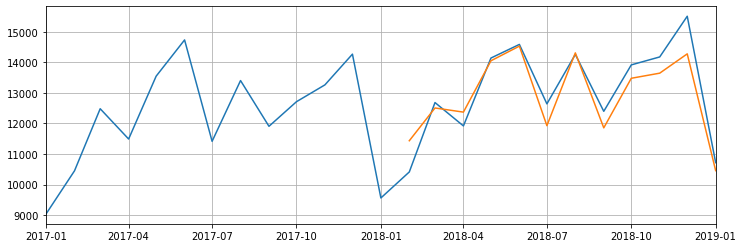

In [40]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x, true_predictions)
plt.show()